In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
np.random.seed(0)
tf.compat.v1.random.set_random_seed(0)

In [2]:
fakepath = '/kaggle/input/model-training-dataset/fake/'
originalpath = "/kaggle/input/model-training-dataset/original/"
fake = []
original = []

In [3]:
for name in tqdm(os.listdir(fakepath)):
    for frame in os.listdir(fakepath + name):
        fake.append(fakepath + name + '/' + frame)

100%|██████████| 1481/1481 [00:01<00:00, 957.66it/s]


In [4]:
for name in tqdm(os.listdir(originalpath)):
    for frame in os.listdir(originalpath + name):
        original.append(originalpath + name + '/' + frame)

100%|██████████| 362/362 [00:00<00:00, 906.79it/s]


In [5]:
y = np.ones(len(original))
x = np.zeros(len(fake))
label = np.concatenate([y, x])
names_list = original + fake
new_data, new_label = shuffle(names_list, label,  random_state = 0)
train, test, y_train, y_test = new_data[:-100], new_data[-100:], new_label[:-100], new_label[-100:]

In [14]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_saturation(img, 1, 3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.resize(img, [75, 75])
    return img

def get_label(file_path):
    cat = tf.strings.split(file_path, '/')[4]
    if cat == b'fake':
        return 1
    return 0

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
num_threads, num_epochs, train_len = 5, 3000, len(train) 
train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [16]:
train_ds = train_ds.shuffle(train_len)
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(1)

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3(weights='imagenet', include_top=False, input_shape = (75, 75, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [18]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
for layer in model.layers[:87]:
    layer.trainable = False

In [20]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(
    learning_rate= lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
tp = tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
tn = tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None)
fp = tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
fn = tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)

In [21]:
classifier = Sequential()
classifier.add(model)
classifier.add(Flatten())
classifier.add(Dense(1024, activation='relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy', tp,tn,fp,fn])

In [22]:
history = classifier.fit(train_ds, epochs = 20, shuffle=True, batch_size=64)

Epoch 1/20
944/944 [==============================] - 55s 58ms/step - loss: 2.9419 - accuracy: 0.7729 - true_positives: 46495.0000 - true_negatives: 191.0000 - false_positives: 12958.0000 - false_negatives: 761.0000
Epoch 2/20
944/944 [==============================] - 55s 58ms/step - loss: 0.5342 - accuracy: 0.7819 - true_positives: 47229.0000 - true_negatives: 2.0000 - false_positives: 13147.0000 - false_negatives: 27.0000
Epoch 3/20
944/944 [==============================] - 55s 58ms/step - loss: 0.5290 - accuracy: 0.7820 - true_positives: 47233.0000 - true_negatives: 3.0000 - false_positives: 13146.0000 - false_negatives: 23.0000
Epoch 4/20
944/944 [==============================] - 54s 58ms/step - loss: 0.5313 - accuracy: 0.7820 - true_positives: 47231.0000 - true_negatives: 3.0000 - false_positives: 13146.0000 - false_negatives: 25.0000
Epoch 5/20
944/944 [==============================] - 55s 58ms/step - loss: 0.5324 - accuracy: 0.7819 - true_positives: 47229.0000 - true_negativ

In [23]:
print(history.history.keys())
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives'])


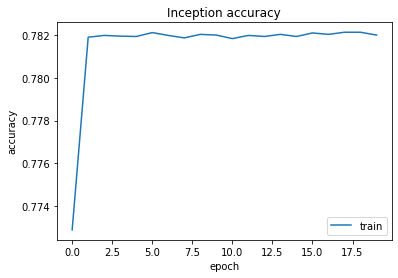

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Inception accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


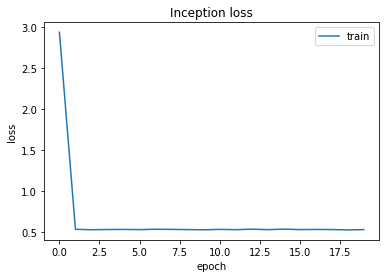

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Inception loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()